In [1]:
import pandas as pd
import os
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score, auc
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
import random
from tensorflow.keras.models import load_model
import os
import shutil
from PIL import Image


In [2]:


path_train = '/Users/jacar/Documents/Maestria/Machine Learning/Proyecto/Train'
path_train_modi = '/Users/jacar/Documents/Maestria/Machine Learning/Proyecto/Train_modi'
path_test = '/Users/jacar/Documents/Maestria/Machine Learning/Proyecto/test'

def imagen_90(image_path):
    imagen = Image.open(image_path)
    imagen_rgb = imagen.convert('RGB')
    return imagen_rgb.rotate(90)

def imagen_hor(image_path):
    imagen = Image.open(image_path)
    imagen_rgb = imagen.convert('RGB')
    return imagen_rgb.transpose(Image.FLIP_LEFT_RIGHT)

def imagen_ver(image_path):
    imagen = Image.open(image_path)
    imagen_rgb = imagen.convert('RGB')
    return imagen_rgb.transpose(Image.FLIP_TOP_BOTTOM)

def cambio_carpetas(path, path_destino):
    imagenes = []
    count = 0

    for directorio, _, archivos in os.walk(path):
        for archivo in archivos:
            if archivo.lower().endswith(('.jpg', '.png', '.jpeg')):
                archivo_path = os.path.join(directorio, archivo)
                imagenes.append(archivo_path)
    
    for img_path in imagenes:
        rel_path = os.path.relpath(img_path, path)
        parts = rel_path.split(os.sep)
        
        if len(parts) > 1 and parts[0] == 'Packages':
            continue
            
        if len(parts) > 1:
            class_folder = parts[0]
        else:
            class_folder = 'unknown'

        dest_dir = os.path.join(path_destino, class_folder)
        os.makedirs(dest_dir, exist_ok=True)
        
        filename = os.path.basename(img_path)
        name, ext = os.path.splitext(filename)
        
        try:
            shutil.copy(img_path, os.path.join(dest_dir, filename))
            imagen_90(img_path).save(os.path.join(dest_dir, f"{name}_90{ext}"))
            imagen_hor(img_path).save(os.path.join(dest_dir, f"{name}_hor{ext}"))
            imagen_ver(img_path).save(os.path.join(dest_dir, f"{name}_ver{ext}"))
            
            count += 1
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
    
    print(f"Successfully processed {count} images")
if __name__ == "__main__":
    cambio_carpetas(path_train, path_train_modi)

Successfully processed 209 images


In [3]:
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=20, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True, 
                                   fill_mode='nearest')

In [4]:
img_height = 348
img_width = 348
batch_size = 3

In [5]:
train_generator = train_datagen.flow_from_directory(
    path_train_modi,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') 

Found 836 images belonging to 3 classes.


In [6]:
val_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
val_generator = val_datagen.flow_from_directory(
    path_test,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') 

Found 50 images belonging to 3 classes.


In [8]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

C:\Users\jacar\AppData\Local\Temp\ipykernel_25820\2631993559.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))


In [9]:
for layer in base_model.layers[:100]:
    layer.trainable = False
for layer in base_model.layers[100:]:
    layer.trainable = True


In [10]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax') 
])


In [11]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [12]:

history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)


c:\Users\jacar\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 101s 331ms/step - accuracy: 0.5307 - loss: 1.0197 - val_accuracy: 0.4000 - val_loss: 3.1901
Epoch 2/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 88s 317ms/step - accuracy: 0.6579 - loss: 0.7565 - val_accuracy: 0.4400 - val_loss: 2.2109
Epoch 3/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 88s 315ms/step - accuracy: 0.7282 - loss: 0.6622 - val_accuracy: 0.5600 - val_loss: 1.6529
Epoch 4/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 89s 317ms/step - accuracy: 0.7727 - loss: 0.5469 - val_accuracy: 0.6400 - val_loss: 1.3667
Epoch 5/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 89s 318ms/step - accuracy: 0.7794 - loss: 0.5107 - val_accuracy: 0.6400 - val_loss: 1.2498
Epoch 6/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 90s 321ms/step - accuracy: 0.8143 - loss: 0.4145 - val_accuracy: 0.6600 - val_loss: 1.9341
Epoch 7/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 89s 321ms/step - accuracy: 0.8674 - loss: 0.3526 - val_accuracy: 0.7400 - val_loss: 1.9035
Epoch 8/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 86s 310ms/step - accuracy: 0.8755 - loss: 

In [13]:
model.save('/Users/jacar/Documents/Maestria/Machine Learning/Proyecto/Model_final.h5')

In [14]:
model = load_model("/Users/jacar/Documents/Maestria/Machine Learning/Proyecto/Model_final.h5")

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 11, 11, 1280)   │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,915,397 (11.12 MB)

 Trainable params: 2,518,851 (9.61 MB)

 Non-trainable params: 396,544 (1.51 MB)

 Optimizer params: 2 (12.00 B)

In [15]:
score = model.evaluate(val_generator, verbose=1)
print(f'Pérdida: {score[0]}, Precisión: {score[1]}')


17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 224ms/step - accuracy: 0.7115 - loss: 1.4825
Pérdida: 1.5730109214782715, Precisión: 0.699999988079071


In [16]:
X_test = []
y_test = []

for i in range(len(val_generator)):
    batch_x, batch_y = next(val_generator)
    X_test.append(batch_x)
    y_test.append(batch_y)


X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

print("Forma de X_test:", X_test.shape) 
print("Forma de y_test:", y_test.shape)  


Forma de X_test: (50, 348, 348, 3)
Forma de y_test: (50, 3)


In [17]:
y_test = np.argmax(y_test, axis=1)

In [18]:
y_test

array([2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 0, 1,
       2, 2, 1, 1, 1, 0, 2, 0, 0, 1, 1, 1, 2, 1, 0, 2, 2, 1, 2, 1, 1, 1,
       0, 2, 1, 2, 1, 2], dtype=int64)

In [19]:
y_pred = model.predict(X_test)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step


In [20]:
y_pred = np.argmax(y_pred, axis=1)


In [21]:
y_pred

array([2, 2, 0, 0, 2, 0, 0, 2, 2, 0, 2, 1, 1, 0, 2, 1, 2, 1, 2, 1, 2, 1,
       2, 2, 2, 1, 1, 0, 2, 0, 0, 1, 2, 1, 2, 1, 0, 2, 2, 1, 0, 1, 0, 1,
       2, 0, 1, 2, 1, 0], dtype=int64)

In [ ]:
print("Precision:")
print("- Test:", precision_score(y_test, y_pred, average='weighted'))
print("\nRecall:")
print("- Test:", recall_score(y_test, y_pred, average='weighted'))
print("\nF1:")
print("- Test:", f1_score(y_test, y_pred, average='weighted'))

Precision:
- Test: 0.765142857142857

Recall:
- Test: 0.7

F1:
- Test: 0.7216161616161617


In [23]:
class_names = val_generator.class_indices
print(class_names)

{'Acero_expuesto': 0, 'Grietas_Fisuras': 1, 'Hormiguero': 2}


In [24]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred,target_names=list(class_names)))

                 precision    recall  f1-score   support

 Acero_expuesto       0.36      0.62      0.45         8
Grietas_Fisuras       1.00      0.80      0.89        20
     Hormiguero       0.70      0.64      0.67        22

       accuracy                           0.70        50
      macro avg       0.69      0.69      0.67        50
   weighted avg       0.77      0.70      0.72        50



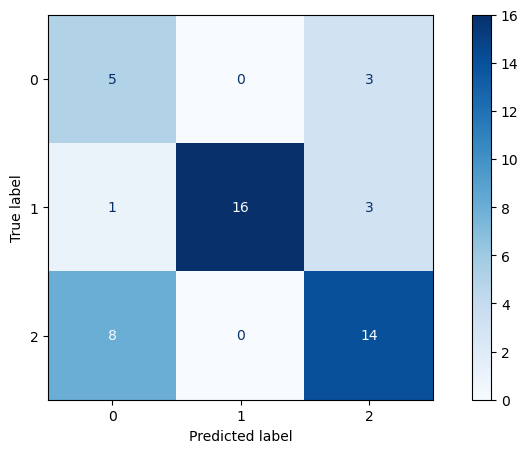

In [25]:

from sklearn import metrics
from sklearn.metrics import confusion_matrix


cfn_matrix  = confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cfn_matrix)
fig, ax = plt.subplots(figsize=(10, 5))
cm_display.plot(ax=ax, cmap='Blues')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

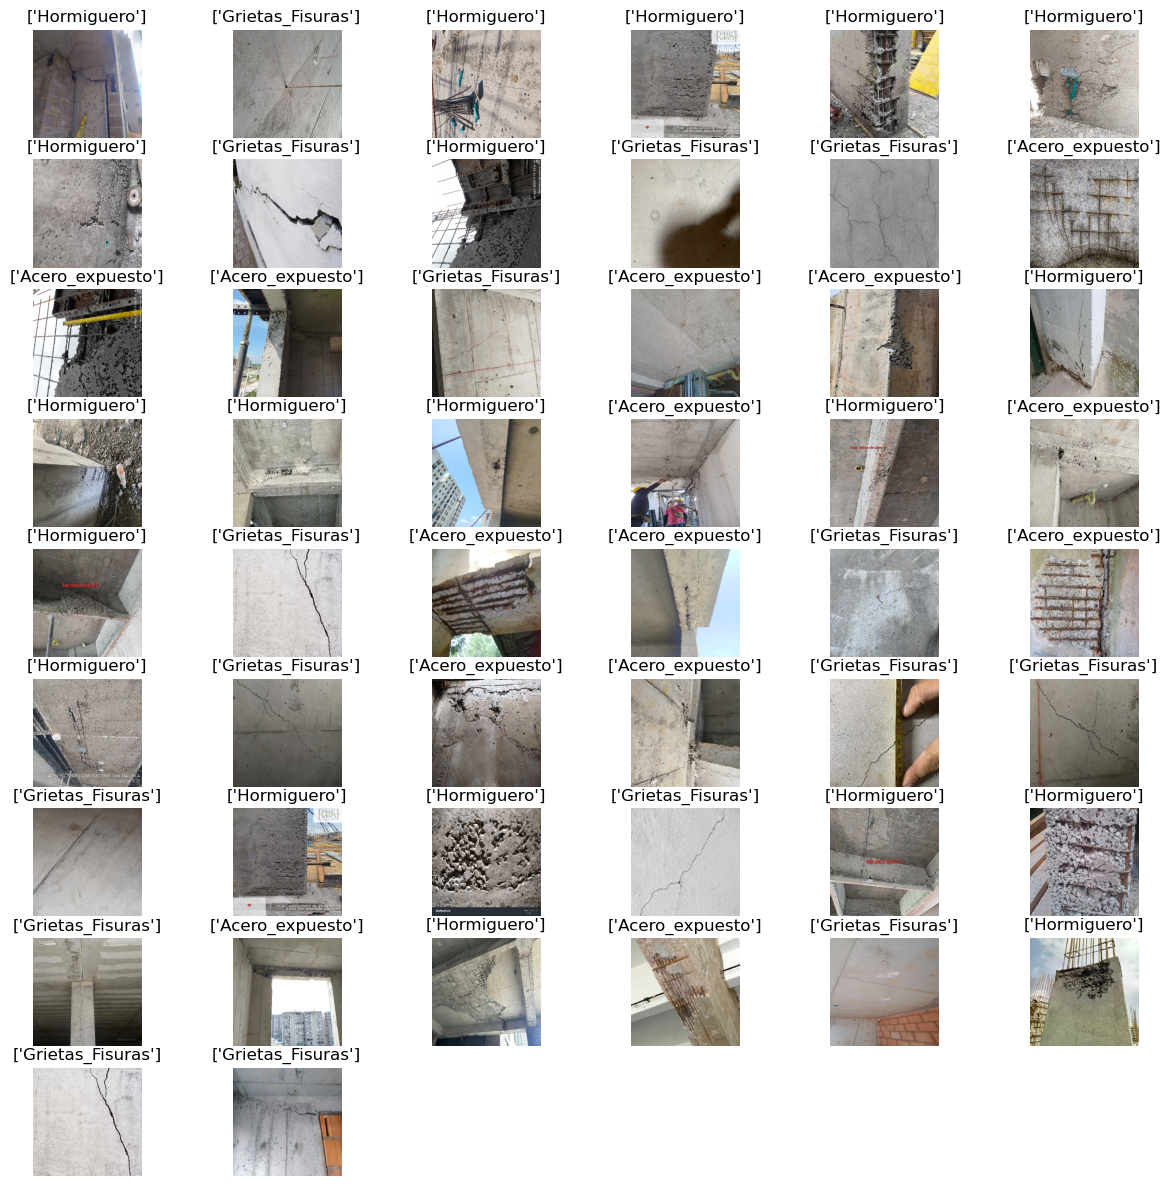

In [26]:
path_validacion = '/Users/jacar/Documents/Maestria/Machine Learning/Proyecto/test' 
imagenes=[]
for directorio, _, archivos in os.walk(path_validacion):
        for archivo in archivos:
            if archivo.lower().endswith(('.jpg', '.png', '.jpeg')):
                archivo_path = os.path.join(directorio, archivo)
                imagenes.append(archivo_path)


imagenes = random.sample(imagenes, 50)

cont=0
plt.figure(figsize=(15, 25))
for i in imagenes : 
    img_path = i
    img = image.load_img(img_path, target_size=(348, 348))  
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    prediccion = model.predict(img_array)
    clase_predicha = np.argmax(prediccion, axis=1)

    clave = [clave for clave, valor in class_names.items() if valor == clase_predicha]
    ax = plt.subplot(15, 6,cont+1)
    plt.imshow(np.squeeze(img_array))
    plt.title(clave)
    plt.axis("off")
    cont+= 1


plt.show()